# Run torsion scans

In [38]:
import os
import pickle
import numpy as np
from openmmtools.integrators import LangevinIntegrator
from openmmtools import states
from openmmtools.states import ThermodynamicState, CompoundThermodynamicState, SamplerState
from perses.annihilation.lambda_protocol import RelativeAlchemicalState, LambdaProtocol, AlchemicalState
from openmmtools.alchemy import AbsoluteAlchemicalFactory, AlchemicalRegion, AlchemicalState
from simtk import openmm, unit
from tqdm import tqdm
import mdtraj as md
from openmmtools.mcmc import MCDihedralRotationMove, LangevinSplittingDynamicsMove
import math
from matplotlib import pyplot as plt
import logging
import copy
from openmmtools import cache
import scipy
from perses.tests.test_topology_proposal import generate_atp, generate_dipeptide_top_pos_sys


logger = logging.getLogger()
logger.setLevel(logging.INFO)


### Define helper function for alchemifying

In [39]:
def alchemify(htf, endstate):

    # Define simulation parameters
    temperature = 300 * unit.kelvin
    nsteps = 10000
    timestep = 4.0 * unit.femtosecond
    platform_name = 'CUDA'
    collision_rate = 1.0 / unit.picoseconds

    system = htf.hybrid_system
    positions = htf.hybrid_positions

    # Alchemify the hybrid system
    atoms_to_alchemify = list(htf._atom_classes['unique_new_atoms']) + list(htf._atom_classes['unique_old_atoms'])

    alch_factory = AbsoluteAlchemicalFactory(consistent_exceptions=False)
    alchemical_region = AlchemicalRegion(alchemical_atoms=list(atoms_to_alchemify), alchemical_torsions=True) 
#                                          annihilate_sterics=True,
#                                          annihilate_electrostatics=True)
#     reference_forces = {force.__class__.__name__: force for force in htf._topology_proposal.new_system.getForces()}
#     print("torsion list: ", alch_factory._build_alchemical_torsion_list(atoms_to_alchemify, reference_forces, htf._topology_proposal.new_system))
    alchemical_system = alch_factory.create_alchemical_system(htf.hybrid_system, alchemical_region)

    # Initialize compound thermodynamic states at different temperatures and alchemical states.
    alchemical_state = AlchemicalState.from_system(alchemical_system)
#     alchemical_state.set_alchemical_parameters(endstate)
    l = 0
    protocol = {'temperature': [300*unit.kelvin],
                'lambda_electrostatics': [l],
                'lambda_sterics': [l],
               'lambda_torsions': [l]}
    compound_state = states.create_thermodynamic_state_protocol(alchemical_system, 
                                                                 protocol=protocol, 
                                                                 composable_states=[alchemical_state])[0]
    compound_state.lambda_sterics = l
    compound_state.lambda_electrostatics = l
    compound_state.lambda_torsions = l
    
    print("sterics ", compound_state.lambda_sterics)
    print("elec ", compound_state.lambda_electrostatics)
    print("torsions ", compound_state.lambda_torsions)
    
    
#     thermodynamic_state = CompoundThermodynamicState(ThermodynamicState(alchemical_system, temperature=temperature), composable_states=[alchemical_state])

    # Set up integrator
    integrator = LangevinIntegrator(temperature, collision_rate, timestep)

    # Set up context
    platform = openmm.Platform.getPlatformByName(platform_name)
    if platform_name in ['CUDA', 'OpenCL']:
        platform.setPropertyDefaultValue('Precision', 'mixed')
    if platform_name in ['CUDA']:
        platform.setPropertyDefaultValue('DeterministicForces', 'true')
        
    context = compound_state.create_context(integrator, platform=platform)    

    context.setPeriodicBoxVectors(*system.getDefaultPeriodicBoxVectors())
    context.setPositions(positions)
    context.setVelocitiesToTemperature(temperature)
    print(compound_state.reduced_potential(context))
    
#     md.Trajectory(np.array(htf.old_positions(positions)), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("nan_before_minimize.pdb")

    # Minimize
    openmm.LocalEnergyMinimizer.minimize(context)

#     # Run equilibration
#     for step in tqdm(range(nsteps)):
#         integrator.step(1)
    
    return context, compound_state

### Sub-class MCDihedralRotationMove

In [3]:
# 1) Remove metropolize part in apply()
# 2) Pass -theta to compute_dihedral()

class MCDihedralRotationMove2(MCDihedralRotationMove):
    def rotate_positions(self, initial_positions):
        """Apply rotation to atom_subset positions.
        Parameters
        ----------
        initial_positions : numpy.ndarray simtk.unit.Quantity
            The positions of all atoms in atom_subset.
        Returns
        -------
        rotated_positions : numpy.ndarray simtk.unit.Quantity
            The rotated positions.
        """
        import math
        import copy
        import numpy as np 
        import logging
        logger = logging.getLogger()
        
        old_angle = self.compute_dihedral(initial_positions[:4])

        if self.desired_angle == -np.inf:
            # Choose a random rotation angle
            theta = random.uniform(-math.pi, math.pi)
        else:
            # If desired_angle is specified, determine rotation angle
            if not (self.desired_angle <= math.pi and self.desired_angle >= -math.pi):
                raise Exception("Desired angle must be less than pi and greater than -pi")
            theta = self.desired_angle - old_angle
        logger.info(f"Rotating by {theta} radians")

        # Make a copy of the initial positions
        new_positions = copy.deepcopy(initial_positions)

        # Find the rotation axis using the initial positions
        axis1 = 1
        axis2 = 2
        rotation_axis = (initial_positions[axis1] - initial_positions[axis2]) / initial_positions.unit

        # Calculate the rotation matrix
        rotation_matrix = self.generate_rotation_matrix(rotation_axis, -theta) ## CHANGED theta to negative

        # Apply the rotation matrix to the target atoms
        for atom_index in range(3, len(self.atom_subset)):
            # Find the reduced position (substract out axis)
            reduced_position = (initial_positions[atom_index] - initial_positions[axis2])._value

            # Find the new positions by multiplying by rot matrix
            new_position = np.dot(rotation_matrix, reduced_position) * initial_positions.unit + initial_positions[axis2]

            # Update the new positions
            new_positions[atom_index][0] = new_position[0]
            new_positions[atom_index][1] = new_position[1]
            new_positions[atom_index][2] = new_position[2]
        
        return new_positions
    def apply(self, thermodynamic_state, sampler_state):
        """Apply a metropolized move to the sampler state.
        Total number of acceptances and proposed move are updated.
        Parameters
        ----------
        thermodynamic_state : openmmtools.states.ThermodynamicState
           The thermodynamic state to use to apply the move.
        sampler_state : openmmtools.states.SamplerState
           The initial sampler state to apply the move to. This is modified.
        """
#         from openmmtools import cache
        import copy
#         timer = Timer()
#         benchmark_id = 'Applying {}'.format(self.__class__.__name__ )
#         timer.start(benchmark_id)

        # Check if we have to use the global cache.
        if self.context_cache is None:
            context_cache = cache.global_context_cache
        else:
            context_cache = self.context_cache

        # Create context, any integrator works.
        context, unused_integrator = context_cache.get_context(thermodynamic_state)
        
        # Compute initial energy. We don't need to set velocities to compute the potential.
        # TODO assume sampler_state.potential_energy is the correct potential if not None?
        sampler_state.apply_to_context(context, ignore_velocities=True)
        initial_energy = thermodynamic_state.reduced_potential(context)

        # Handle default and weird cases for atom_subset.
        if self.atom_subset is None:
            atom_subset = slice(None)
        elif not isinstance(self.atom_subset, slice) and len(self.atom_subset) == 1:
            # Slice so that initial_positions (below) will have a 2D shape.
            atom_subset = slice(self.atom_subset[0], self.atom_subset[0]+1)
        else:
            atom_subset = self.atom_subset

        # Store initial positions of the atoms that are moved.
        # We'll use this also to recover in case the move is rejected.
        if isinstance(atom_subset, slice):
            # Numpy array when sliced return a view, they are not copied.
            initial_positions = copy.deepcopy(sampler_state.positions[atom_subset])
        else:
            # This automatically creates a copy.
            initial_positions = sampler_state.positions[atom_subset]

        # Propose perturbed positions. Modifying the reference changes the sampler state.
        proposed_positions = self._propose_positions(initial_positions)

        # Compute the energy of the proposed positions.
        sampler_state.positions[atom_subset] = proposed_positions
        sampler_state.apply_to_context(context, ignore_velocities=True)
        proposed_energy = thermodynamic_state.reduced_potential(context)

#         # Accept or reject with Metropolis criteria.
#         delta_energy = proposed_energy - initial_energy
#         if (not np.isnan(proposed_energy) and
#                 (delta_energy <= 0.0 or np.random.rand() < np.exp(-delta_energy))):
#             self.n_accepted += 1
#         else:
#             # Restore original positions.
#             sampler_state.positions[atom_subset] = initial_positions
#         self.n_proposed += 1

#         # Print timing information.
#         timer.stop(benchmark_id)
#         #timer.report_timing()
        
        return proposed_energy, sampler_state.positions

### Define run torsion scan function

In [37]:
def run_torsion_scan(htf, endstate, is_old, hybrid_indices, vanilla_indices, other_indices):
    """
    hybrid_indices : list of int
        indices of the dihedral atoms from the hybrid system
    vanilla_indices : list of int
        indices of the dihedral atoms from the vanilla (old or new) system
    other_indices : list of int
        indices of the non-dihedral sidechain atoms to be rotated, from the hybrid system
    """
    
#     d_masses = {}
#     # Set particle masses to 0
#     for index in hybrid_indices:
#         d_masses[index] = htf.hybrid_system.getParticleMass(index)
#         htf.hybrid_system.setParticleMass(index, 0.0)
    
#     # Turn off constraints involving massless particles
#     for i in reversed(range(htf.hybrid_system.getNumConstraints())):
#         p1, p2, d = htf.hybrid_system.getConstraintParameters(i)
#         if p1 in hybrid_indices or p2 in hybrid_indices:
#             if htf.hybrid_system.getParticleMass(p1) == 0*unit.amu or htf.hybrid_system.getParticleMass(p2) == 0*unit.amu:
#                 htf.hybrid_system.removeConstraint(i)
    
    # Create context, compound state
    context, compound_state = alchemify(htf, endstate)
    
    # Create sampler state
    sampler_state = SamplerState.from_context(context)
    
    # Compute current dihedral
    if is_old:
        dihedral = md.compute_dihedrals(md.Trajectory(np.array(htf.old_positions(htf.hybrid_positions)), 
                                                      md.Topology.from_openmm(htf._topology_proposal.old_topology)), 
                                        np.array([vanilla_indices]))[0][0]
    else:
        dihedral = md.compute_dihedrals(md.Trajectory(np.array(htf.new_positions(htf.hybrid_positions)), 
                                                      md.Topology.from_openmm(htf._topology_proposal.new_topology)), 
                                        np.array([vanilla_indices]))[0][0]
    print(dihedral)
    
    # Run scan
    d = {} # key : angle, value : energy
    new_dihedral = dihedral + 0.262
    positions_all = []
    for i in range(25):
        # Add correction if the angle is no longer in the domain of [-pi, pi]
        if new_dihedral > math.pi: 
            new_dihedral = -math.pi + (new_dihedral - math.pi)
        elif new_dihedral < -math.pi:
            new_dihedral = math.pi + (new_dihedral + math.pi)
        
        print(compound_state.reduced_potential(context))
        
        # Apply rotation move
        move = MCDihedralRotationMove2(hybrid_indices + other_indices, desired_angle=new_dihedral) # Rotate the sidechain by 15 degrees
        move.apply(compound_state, sampler_state)
        
        sampler_state.apply_to_context(context)
        energy = compound_state.reduced_potential(context)
        energies = [energy]
#         openmm.LocalEnergyMinimizer.minimize(context)
        d[new_dihedral] = (np.mean(energies), scipy.stats.sem(energies))
        
#         if is_old:
#             positions_all.append(htf.old_positions(positions)/unit.nanometer) # get last positions from last relaxtion
#         else:
#             positions_all.append(htf.new_positions(positions)/unit.nanometer) # get last positions from last relaxtion
        
        # Increment dihedral angle by 15 degrees
        new_dihedral += 0.262
    
    print(f"raw d: {d}")
        
#     # Write out pdb of positions
#     if is_old:
#         md.Trajectory(np.array(positions_all), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("traj.pdb")
#     else:
#         md.Trajectory(np.array(positions_all), md.Topology.from_openmm(htf._topology_proposal.new_topology)).save("traj.pdb")
        
    # Plot scan data
    minimum = min([val[0] for val in list(d.values())])
    print(f"min: {minimum}")
    d_corrected = {}
    for k, v in d.items():
        d_corrected[k] = (v[0] - minimum, v[1])
    print(f"d corrected: {d_corrected}")
    plt.errorbar(list(d_corrected.keys()), [mean for mean, stderr in list(d_corrected.values())], yerr=[stderr for mean, stderr in list(d_corrected.values())], fmt='o')
    plt.show()
    
#     # Set masses back to normal
#     for index in hybrid_indices:
#         compound_state.system.setParticleMass(index, d_masses[index])
#     compound_state.apply_to_context(context)
    
    return d_corrected
    
    

In [5]:
torsion_scans = []

## THR->ALA r-htf in solvent (flattened torsions and exceptions) @ lambda = 0, alchemical region = unique_old + unique_new

In [40]:
data_dir = "/data/chodera/zhangi/perses_benchmark/neq/10/13/"

with open(os.path.join(data_dir, f"13_solvent_0.pickle"), "rb") as f:
    rhtf = pickle.load(f)

# data_dir = "/data/chodera/zhangi/perses_benchmark/neq/10/9/"

# with open(os.path.join(data_dir, f"9_vacuum.pickle"), "rb") as f:
#     rhtf = pickle.load(f)

In [41]:
for atom in rhtf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-C 0
ACE1-O 1
ACE1-CH3 2
ACE1-H1 3
ACE1-H2 4
ACE1-H3 5
THR2-N 6
THR2-CA 7
THR2-C 8
THR2-O 9
THR2-CB 10
THR2-CG2 11
THR2-OG1 12
THR2-H 13
THR2-HA 14
THR2-HB 15
THR2-HG1 16
THR2-HG21 17
THR2-HG22 18
THR2-HG23 19
THR2-CB 1549
THR2-HB1 1550
THR2-HB2 1551
THR2-HB3 1552
NME3-N 20
NME3-C 21
NME3-H 22
NME3-H1 23
NME3-H2 24
NME3-H3 25
HOH4-O 26
HOH4-H1 27
HOH4-H2 28
HOH5-O 29
HOH5-H1 30
HOH5-H2 31
HOH6-O 32
HOH6-H1 33
HOH6-H2 34
HOH7-O 35
HOH7-H1 36
HOH7-H2 37
HOH8-O 38
HOH8-H1 39
HOH8-H2 40
HOH9-O 41
HOH9-H1 42
HOH9-H2 43
HOH10-O 44
HOH10-H1 45
HOH10-H2 46
HOH11-O 47
HOH11-H1 48
HOH11-H2 49
HOH12-O 50
HOH12-H1 51
HOH12-H2 52
HOH13-O 53
HOH13-H1 54
HOH13-H2 55
HOH14-O 56
HOH14-H1 57
HOH14-H2 58
HOH15-O 59
HOH15-H1 60
HOH15-H2 61
HOH16-O 62
HOH16-H1 63
HOH16-H2 64
HOH17-O 65
HOH17-H1 66
HOH17-H2 67
HOH18-O 68
HOH18-H1 69
HOH18-H2 70
HOH19-O 71
HOH19-H1 72
HOH19-H2 73
HOH20-O 74
HOH20-H1 75
HOH20-H2 76
HOH21-O 77
HOH21-H1 78
HOH21-H2 79
HOH22-O 80
HOH22-H1 81
HOH22-H2 82
HOH23-O 83
HOH23-H1 8

In [42]:
for atom in rhtf._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (C) of chain 0 residue 0 (ACE)> 0
<Atom 1 (O) of chain 0 residue 0 (ACE)> 1
<Atom 2 (CH3) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H1) of chain 0 residue 0 (ACE)> 3
<Atom 4 (H2) of chain 0 residue 0 (ACE)> 4
<Atom 5 (H3) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (CA) of chain 0 residue 1 (THR)> 7
<Atom 8 (C) of chain 0 residue 1 (THR)> 8
<Atom 9 (O) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (CG2) of chain 0 residue 1 (THR)> 11
<Atom 12 (OG1) of chain 0 residue 1 (THR)> 12
<Atom 13 (H) of chain 0 residue 1 (THR)> 13
<Atom 14 (HA) of chain 0 residue 1 (THR)> 14
<Atom 15 (HB) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG1) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG21) of chain 0 residue 1 (THR)> 17
<Atom 18 (HG22) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG23) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (C) of chain 0 residue 2 (NME)> 21
<Atom 22 (H) of chain 0 resi

sterics  0.0
elec  0.0
torsions  0.0
1381.0965653566188


INFO:root:Rotating by 0.031127182770459783 radians
INFO:root:Rotating by 0.26199999999999823 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26199999999999934 radians
INFO:root:Rotating by 0.26200000000000034 radians
INFO:root:Rotating by 0.26200000000000057 radians
INFO:root:Rotating by 0.26199999999999973 radians
INFO:root:Rotating by 0.2620000000000005 radians
INFO:root:Rotating by 0.2620000000000018 radians
INFO:root:Rotating by 0.26199999999999873 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999997 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2620000000000007 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Ro

3.0071301
-10432.796189243714
-10432.795029441362
-10432.795029359208
-10432.795027739077
-10432.795029710354
-10432.795032211867
-10432.795027512557
-10432.795033266497
-10432.795032226977
-10432.795029919536
-10432.7950324165
-10432.795031754156
-10432.795030062665
-10432.795028443845
-10432.795030839903
-10432.795033484208
-10432.795028699724
-10432.79503065002
-10432.795028308603
-10432.79502415499
-10432.7950282061
-10432.795031130096
-10432.795025768351
-10432.795032341706
-10432.795026287144
raw d: {-3.014055161152975: (-10432.795029441362, nan), -2.752055161152975: (-10432.795029359208, nan), -2.490055161152975: (-10432.795027739077, nan), -2.228055161152975: (-10432.795029710354, nan), -1.9660551611529749: (-10432.795032211867, nan), -1.7040551611529748: (-10432.795027512557, nan), -1.4420551611529748: (-10432.795033266497, nan), -1.1800551611529748: (-10432.795032226977, nan), -0.9180551611529748: (-10432.795029919536, nan), -0.6560551611529748: (-10432.7950324165, nan), -0.3

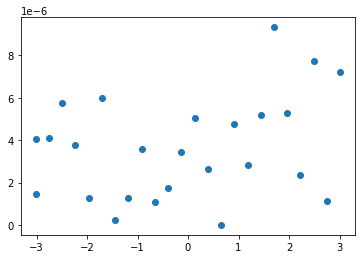

{-3.014055161152975: (4.042845830554143e-06, nan),
 -2.752055161152975: (4.125000486965291e-06, nan),
 -2.490055161152975: (5.7451306929579005e-06, nan),
 -2.228055161152975: (3.7738536775577813e-06, nan),
 -1.9660551611529749: (1.272341251024045e-06, nan),
 -1.7040551611529748: (5.9716512623708695e-06, nan),
 -1.4420551611529748: (2.1771120373159647e-07, nan),
 -1.1800551611529748: (1.2572309060487896e-06, nan),
 -0.9180551611529748: (3.5646717151394114e-06, nan),
 -0.6560551611529748: (1.0677085811039433e-06, nan),
 -0.3940551611529748: (1.7300517356488854e-06, nan),
 -0.13205516115297478: (3.421542714932002e-06, nan),
 0.12994483884702523: (5.040363248554058e-06, nan),
 0.39194483884702525: (2.6443049137014896e-06, nan),
 0.6539448388470253: (0.0, nan),
 0.9159448388470253: (4.784484190167859e-06, nan),
 1.1779448388470253: (2.834187398548238e-06, nan),
 1.4399448388470253: (5.175605110707693e-06, nan),
 1.7019448388470253: (9.32921830099076e-06, nan),
 1.9639448388470253: (5.278108

In [43]:
# THR->ALA -- THR at lambda = 0
run_torsion_scan(rhtf, 0, True, [6, 7, 10, 12], [6, 7, 10, 12], [11, 15, 16 ,17, 18, 19]) # solvent
# run_torsion_scan(rhtf, 0, True, [6, 8, 10, 18], [6, 8, 10, 18], [13, 14, 15, 16 ,17, 19]) # vacuum